In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [3]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [4]:
# Add labelname to the dataset
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df['labelname'] = df['label'].apply(label_int2str)
print(df.head())

                                                text  label labelname
0                            i didnt feel humiliated      0   sadness
1  i can go from feeling so hopeless to so damned...      0   sadness
2   im grabbing a minute to post i feel greedy wrong      3     anger
3  i am ever feeling nostalgic about the fireplac...      2      love
4                               i am feeling grouchy      3     anger


1. Dataexploring mithilfe von Pandas und Matplotlib

Matplotlib is building the font cache; this may take a moment.


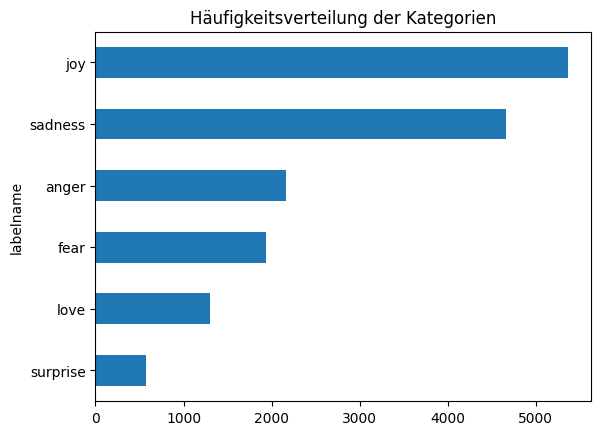

In [6]:
import matplotlib.pyplot as plt

df['labelname'].value_counts(ascending=True).plot.barh()
plt.title('Häufigkeitsverteilung der Kategorien')
plt.show()

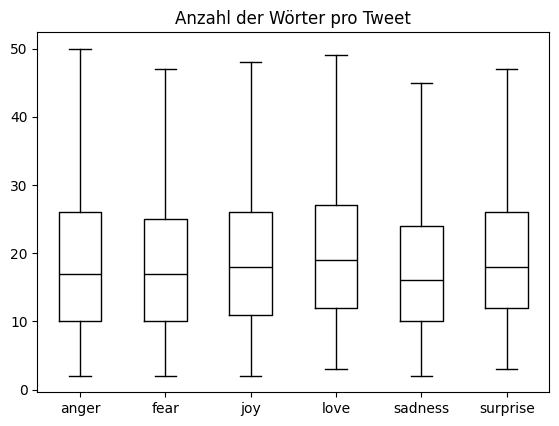

In [8]:
# Wie lange sind unsere Tweets?
df["Anzahl der Wörter pro Tweet"] = df['text'].str.split().apply(len)
df.boxplot("Anzahl der Wörter pro Tweet", by="labelname", grid=False, showfliers=False, color="black")
plt.suptitle('')
plt.xlabel("")
plt.show()

Die Länge der Tweets liegt bei ~15 Wörtern je Emotion. Selbst die längsten Tweets liegen unter der maximalen Kontextlänge von DistilBERT. Das bedeutet es ist eine Kürzung notwendig. Im folgenden konvertieren wir nun die Rohtexte in ein Format, dass sich für die Transformer-Bibliothek eignet. DataFrame-Format wird auch zurück gesetzt, da es nicht mehr benötigt wird. 

In [9]:
# Zurücksetzen des DataFormats
emotions.reset_format()

Vom Text zu Tokens: 

In [12]:
from transformers import AutoTokenizer

# Laden des Tokenizers
# DistilBERT ist ein vortrainiertes Modell, das wir für unser Sentiment Analysis Modell verwenden
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
# Sehen wir uns an, wie der Tokenizer funktioniert
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [14]:
# Nachdem wir nun die input_ids vorliegen haben, können wir sie wieder in Tokens konvertieren:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [15]:
# So bringen wir mit dem AutoTokenizer unsere tokens zurück in eine Zeichenkette: 
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


VORSICHT! Wenn ich ein vortrainiertes Modell nutze, dann muss ich darauf achten den gleichen Tokenizer zu verwenden, der auch beim Training verwendet wurde. Aus Sicht des Modells ist ein Wechsel des Tokenizers wie eine Umstellung des Vokabulars. 